In [1]:
import os

import numpy as np
import itertools
from itertools import cycle
import pandas as pd

import umap

import matplotlib.pyplot as plt
from matplotlib import offsetbox

import sklearn
from sklearn import manifold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, metrics
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, Conv1D, Deconvolution2D, MaxPooling1D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.text import *
from keras.utils import np_utils
from keras.models import model_from_json, load_model
from keras.regularizers import *
from keras.callbacks import CSVLogger
from keras import backend as K

from time import time
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from collections import Counter

/home/josh/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/josh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/josh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1

In [2]:
os.environ['PYTHONHASHSEED'] = '0'

## The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(42)

## Force TensorFlow to use single thread.
## Multiple threads are a potential source of
## non-reproducible results.
## For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=0, inter_op_parallelism_threads=0) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

## The below tf.set_random_seed() will make random number generation
## in the TensorFlow backend have a well-defined initial state.
## For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## Data loader
This reads in the mosquito data from a csv file save stores the data in appropriate variables for later use

In [5]:
# df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata/mosquitos_country.dat", '\t')
df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata_update_19_02/mosquitoes_country_LM_5_0.dat", '\t')
df.head(10)

df = df[df['Country']!='VB']

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

Species_counts = df.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df.groupby('Age').size()
print('{}'.format(age_counts))
country_counts = df.groupby('Country').size()
print('{}'.format(country_counts))

X = df.iloc[:,6:-1]
y_age = df["Age"]
y_species = df["Species"]
y_status = df["Status"]
y_country = df["Country"]
y_age_groups = df["AgeGroup"]
y_rearcnd = df["RearCnd"]


print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))
print('shape of y country : {}'.format(y_country.shape))
print('shape of y age groups : {}'.format(y_age_groups.shape))
print('shape of y rearcnd : {}'.format(y_rearcnd.shape))

X = np.asarray(X)
y_age = np.asarray(y_age)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)
y_country = np.asarray(y_country)
y_age_groups = np.asarray(y_age_groups)
y_rearcnd = np.asarray(y_rearcnd)

Species
AA    17251
AC     5995
AG    17481
dtype: int64
Status
BF     8611
GR     6737
SF    22102
UN     3277
dtype: int64
RearCnd
TF     9618
TL    27824
VF     3285
dtype: int64
Age
1     1596
2     1150
3     1530
4     2019
5     2323
6     2379
7     2630
8     2560
9     2796
10    2673
11    2704
12    2584
13    2816
14    2695
15    2869
16    2664
17    2739
dtype: int64
Country
B     8677
S     6430
T    25620
dtype: int64
shape of X : (40727, 1625)
shape of y age : (40727,)
shape of y species : (40727,)
shape of y status : (40727,)
shape of y country : (40727,)
shape of y age groups : (40727,)
shape of y rearcnd : (40727,)


## Functions for plotting embedded data

In [18]:
# Scale and visualize the embedding vectors for mosquito Age
def plot_embedding_Age(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        indicies = np.where(Species==uniqueSpecies[i])[0]
        plt.scatter(X[indicies, 0], X[indicies, 1], c=y[indicies], cmap=colorMap, s=5)         
        plt.xticks([]), plt.yticks([])
        plt.title(uniqueSpecies[i])
    plt.colorbar()    
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")

# Scale and visualize the embedding vectors for mosquito Country
def plot_embedding_country(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'k']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'S':
                    y_label.append('Glasgow')
                elif lab == 'T':
                    y_label.append('Ifakara')
                elif lab == 'B':
                    y_label.append('Bobo')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis', fontsize=18)
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii', fontsize=18)
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae', fontsize=18)
    fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.01), fontsize=18, markerscale=4.)
    
    plt.savefig(saveDir+title+".png")
    
# Scale and visualize the embedding vectors for mosquito RearCnd
def plot_embedding_rearCnd(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'TF':
                    y_label.append('Time Course Field')
                elif lab == 'TL':
                    y_label.append('Time Course Lab')
                elif lab == 'VF':
                    y_label.append('Validation Field')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis', fontsize=18)
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii', fontsize=18)
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae', fontsize=18)
    fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.01), fontsize=18, markerscale=4.)

    plt.savefig(saveDir+title+".png")
    


## Create UMAP embedding
This creates an embedding using UMAP with 2 dimensions for easy visualisations

In [7]:
saveDir = '/home/josh/Documents/Mosquito_Project/MIRS-CNN/data-visualisation/UMAP/'

## Scale features
features = X
X_scaled = StandardScaler().fit_transform(X=features)

# for num_neighbours, num_metric in ([[3,'chebyshev'],[4,'chebyshev'],[4,'correlation'],[5,'braycurtis'],[5,'correlation'],[6,'canberra']]):
#     for num_min_dist in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
num_neighbours = 32
num_min_dist = 0.7
num_metric = 'chebyshev'
## PCA embedding of the digits dataset
dimensions = 2
print('Shape of X : {}'.format(X.shape))
print("Computing UMAP projection")
t0 = time()
#reducer = umap.UMAP(random_state=42, n_components=dimensions)
reducer = umap.UMAP(random_state=42, n_components=dimensions, n_neighbors=num_neighbours, metric=num_metric, min_dist=num_min_dist)
embedding = reducer.fit(X_scaled)
transformed = reducer.transform(X_scaled)
print('Embedding time: {}'.format(time()-t0))



Shape of X : (40727, 1625)
Computing UMAP projection
Embedding time: 269.4628348350525


## Plotting for age

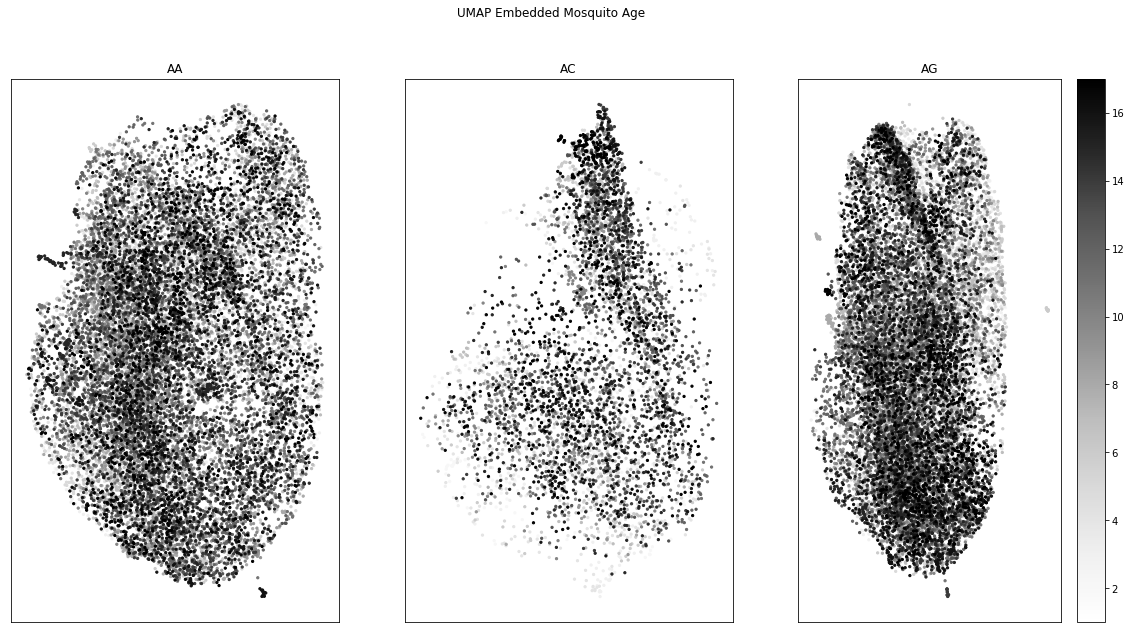

In [8]:
## Call plotting function
plot_embedding_Age(transformed, y_age, y_species, saveDir, ('UMAP Embedded Mosquito Age'))

## Plotting for country

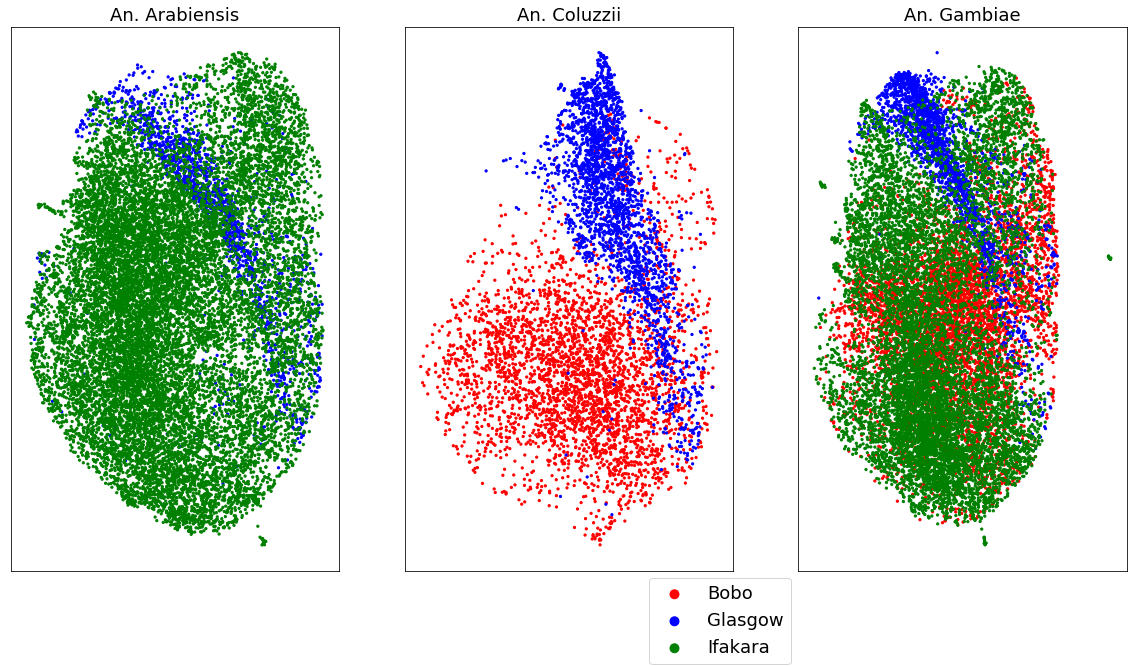

In [9]:
plot_embedding_country(transformed, y_country, y_species, saveDir, ('UMAP_Embedded_Mosquito_Country'), colorMap='Set1')


## Plotting for rear cnd

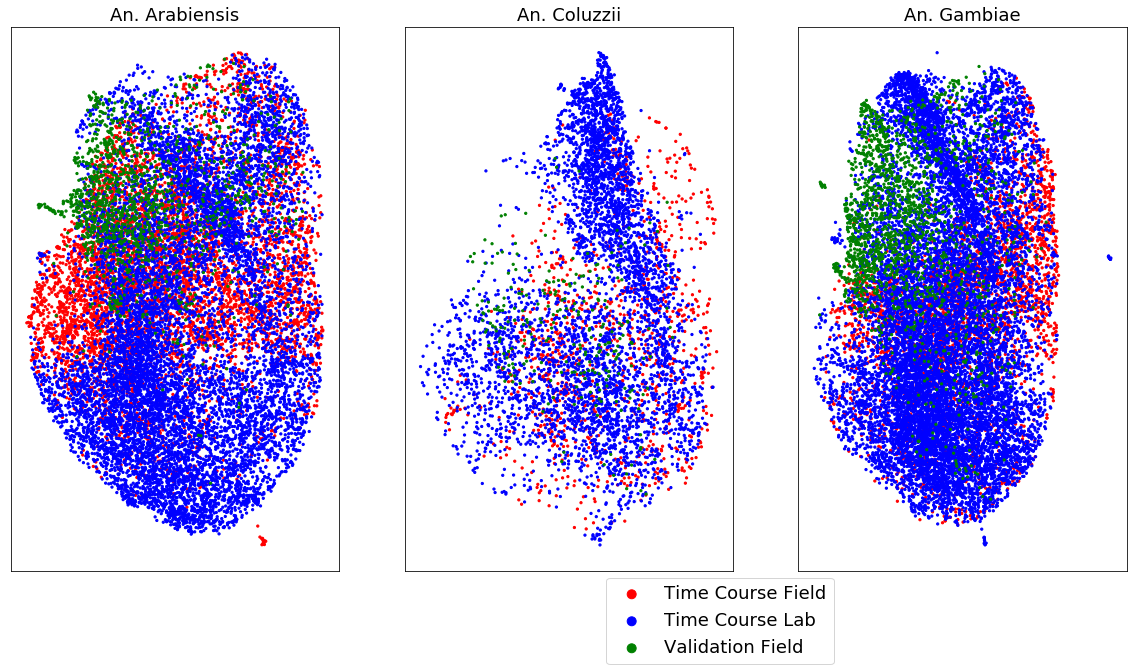

In [12]:
## Call plotting function
plot_embedding_rearCnd(transformed, y_rearcnd, y_species, saveDir, ('UMAP_Embedded_Mosquito_RearCnd'), colorMap='Set1')
